In [1]:
from astropy.io import fits # to read in FITS files
from astropy.wcs import WCS # to read coordinates
from reproject import reproject_interp # to align images
import numpy as np # math applied to arrays (important, no need to read pixel for pixel!)
from matplotlib import pyplot as plt # plot library 
from astropy.visualization import ZScaleInterval # create minimum and maximum Z values for plotting 
import astropy.units as u
from astropy.coordinates import SkyCoord
import glob # finding pathnames
import os # os.path to manipulate file paths 
from scipy.stats import rankdata
from astropy.stats import sigma_clip as astropy_sigma_clip
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection

region_size_define = 4


In [2]:
# Returns the header and data of a .fit file.
def get_data(data_im):
    hdu = fits.open(data_im)[0]
    header = hdu.header 
    data = hdu.data
    wcs = WCS(hdu.header)
    return header, data, wcs

# Aligns image with the reference coordinates.
def reproject_image(image_filename, wcs_ref):
    hdu = fits.open(image_filename)[0]
    array, footprint = reproject_interp(hdu, wcs_ref)
    return array

# Function to calculate distances from the center
def calc_distance(image, x_center, y_center):
    # Make a coordinate grid of the image
    y_indices, x_indices = np.indices(image.shape)
    # Calculate the distance from the chosen center
    distances = np.sqrt((x_indices - x_center) ** 2 + (y_indices - y_center) ** 2)
    return distances

# Calculate background noise
def calc_background(image, xmin, xmax, ymin, ymax):
    background_region = image[ymin:ymax, xmin:xmax]
    average = np.mean(background_region)
    return average

# Calculate standarddeviation on counts
def std_counts(image):
    return np.sqrt(image)

# Calculates standarddeviation on magnitude
def std_mag(image, err_zp):
    return np.sqrt(((2.5*np.sqrt(image))/image*np.log(10))**2 + err_zp**2)

# Function to calculate the flux
def convert_to_magnitude(image, zero_point):
    # Add a min flux to avoid log(0)
    min_flux = 1e-10
    flux = -2.5 * np.log10(np.maximum(image,min_flux)/60) + zero_point
    flux = np.where(image == 0, -1000, flux)
    return flux

#Function to convert g' - r' to B - V
def gr_to_BV(color_index):
    return ((color_index/1.10) + 0.19)

# Calculates the color index
def calc_color_index(filter1, filter2):
    color_index = filter1 - filter2
    return color_index

# Divide the images into sections and calculate the average magnitude for each section
def section_image(image, region_size=(region_size_define, region_size_define)):
    y_len, x_len = image.shape
    x_sections = x_len // region_size[0]
    y_sections = y_len // region_size[1]
    averages = np.zeros((y_sections, x_sections))
    
    for i in range(y_sections):
        for j in range(x_sections):
            y_start = i * region_size[1]
            y_end = y_start + region_size[1]
            x_start = j * region_size[0]
            x_end = x_start + region_size[0]
            region = image[y_start:y_end, x_start:x_end]
            averages[i, j] = np.nanmean(region)
            
    return averages


In [3]:
# Change the data with whatever fit you're using.
# Easiest to 'copy relative path' if you're using the GitHub folder.
# Don't forget to change \ to /.
fit_g = "NGC_4449_g_stack_astrometry.fits"
fit_r = "NGC_4449_r_stack_astrometry.fits"
fit_L = 'NGC_4449_L_stack_astrometry.fits'
fit_ha = 'NGC_4449_ha_stack_stephanie_astrometry.fits'

header_L, dat_L, wcs_L = get_data(fit_L)
header_g, dat_g, wcs_g = get_data(fit_g)
header_r, dat_r, wcs_r = get_data(fit_r)
header_ha, dat_ha, wcs_ha = get_data(fit_ha)


In [4]:
# Reference coordinates.
wcs_ref = WCS(header_g)

aligned_g = reproject_image(fit_g, wcs_ref)
print("Align g: done!")
aligned_r = reproject_image(fit_r, wcs_ref)
print("Align r: done!")
aligned_ha = reproject_image(fit_ha, wcs_ref)
print("Align h-alpha: done!")
aligned_L = reproject_image(fit_L, wcs_ref)
print("Align L: done!")


Align g: done!
Align r: done!
Align h-alpha: done!
Align L: done!


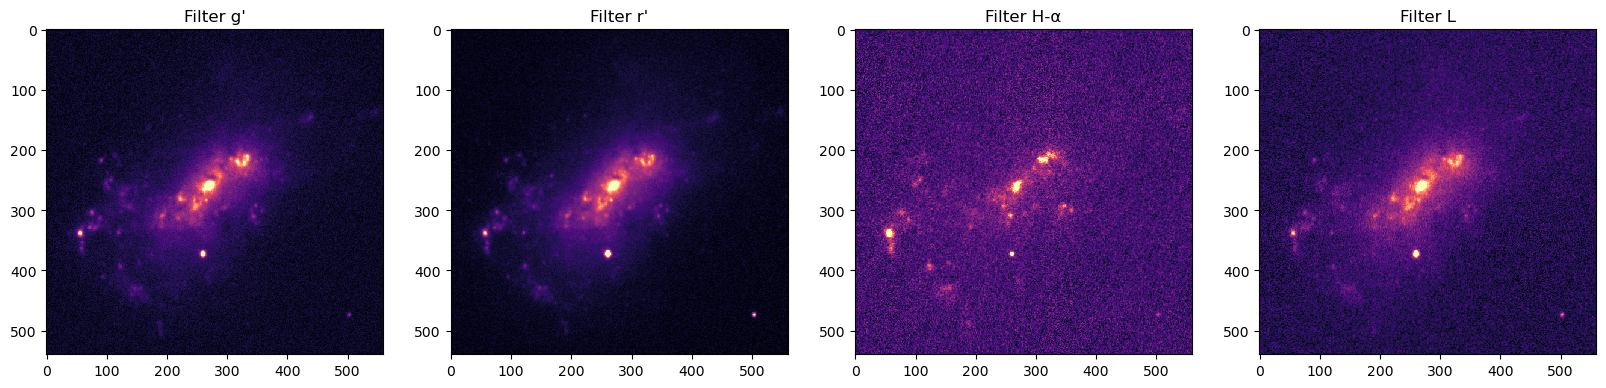

In [5]:
# Calculate distance from the center of each point
hdu = fits.open(fit_g)[0]
image_data = aligned_g
wcs = WCS(hdu.header)

# Define the ICRS coordinates of the galaxy center
ra_center = 187.046325  # Right Ascension in degrees
dec_center = 44.093558  # Declination in degrees

# Create a SkyCoord 
sky_coord = SkyCoord(ra=ra_center * u.deg, dec=dec_center * u.deg, frame='icrs')

# Convert WCS coordinates to pixel coordinates
x_center, y_center = wcs.world_to_pixel(sky_coord)

distances = calc_distance(image_data, x_center, y_center)

# x, y limits to crop images (1600, 2400, 1800, 2400 to see only NGC 4449)
x_min, x_max, y_min, y_max = 1720, 2280, 1800, 2340

# Crop the images
cropped_g= aligned_g[y_min:y_max, x_min:x_max]
cropped_r = aligned_r[y_min:y_max, x_min:x_max]
cropped_ha = aligned_ha[y_min:y_max, x_min:x_max]
cropped_L = aligned_L[y_min:y_max, x_min:x_max]
cropped_distances = distances[y_min:y_max, x_min:x_max]

# Visualize the cropped images
quantiles_g = np.percentile(cropped_g, (0.1, 99.9))
quantiles_r = np.percentile(cropped_r, (0.1, 99.9))
quantiles_ha = np.percentile(cropped_ha, (0.1, 99.9))
quantiles_L = np.percentile(cropped_L, (0.1, 99.9))
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(cropped_g, cmap='magma', vmin = quantiles_g[0], vmax = quantiles_g[1], interpolation = 'nearest')
axs[0].set_title("Filter g'")
axs[1].imshow(cropped_r, cmap='magma', vmin = quantiles_r[0], vmax = quantiles_r[1], interpolation = 'nearest')
axs[1].set_title("Filter r'")
axs[2].imshow(cropped_ha, cmap='magma', vmin = quantiles_ha[0], vmax = quantiles_ha[1], interpolation = 'nearest')
axs[2].set_title("Filter H-α")
axs[3].imshow(cropped_L, cmap='magma', vmin = quantiles_L[0], vmax = quantiles_L[1], interpolation = 'nearest')
axs[3].set_title('Filter L')

plt.show()


In [40]:
xmin, xmax = 0, 75
ymin, ymax = 0, 60

bg_mean_L = calc_background(cropped_L, xmin, xmax, ymin, ymax)
bg_mean_ha = calc_background(cropped_ha, xmin, xmax, ymin, ymax)
bg_mean_r = calc_background(cropped_r, xmin, xmax, ymin, ymax)
bg_mean_g = calc_background(cropped_g, xmin, xmax, ymin, ymax)

no_bg_g = cropped_g - 244.13093010864273
no_bg_r = cropped_r - 332.6516227990238
no_bg_ha = cropped_ha - 101.7104743544874
no_bg_L = cropped_L - 1217.66174153108

# Remove hashtags to enable sigma clipping
def sigma_clip(image, sigma, maxiters):
    #clipped_data = astropy_sigma_clip(image, sigma=sigma, maxiters=maxiters, cenfunc='median', stdfunc='std')
    #Fill up masked points with NaN values
    #return clipped_data.filled(np.nan)
    return image

sigma = 10
maxiters = 3
clipped_ha = sigma_clip(no_bg_ha, sigma, maxiters)
clipped_g = sigma_clip(no_bg_g, sigma, maxiters)
clipped_L = sigma_clip(no_bg_L, sigma, maxiters)
clipped_r = sigma_clip(no_bg_r, sigma, maxiters)



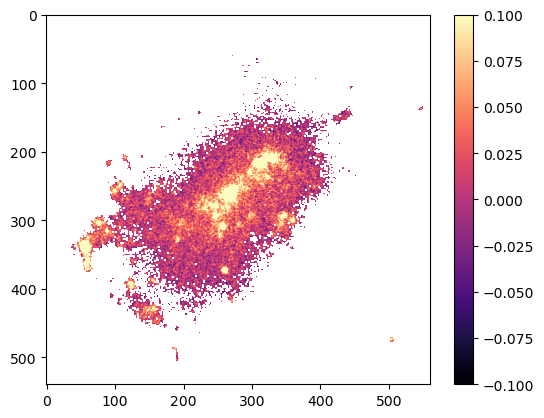

In [41]:
# Mask backgroundpoints

def mask_bg(array_2d, threshold):
    # Create a boolean mask where elements are True if they are greater than or equal to the threshold
    mask = array_2d >= threshold
    return mask

def apply_combined_mask(array1, array2, array3, mask1, mask2, fill_value=np.nan):
    # Combine the masks using a logical AND operation
    combined_mask = mask1 & mask2
    # Create copies of the arrays
    masked_array1 = np.copy(array1)
    masked_array2 = np.copy(array2)
    masked_array3 = np.copy(array3)
    # Apply the combined mask to all arrays
    masked_array1[~combined_mask] = fill_value
    masked_array2[~combined_mask] = fill_value
    masked_array3[~combined_mask] = fill_value
    return masked_array1, masked_array2, masked_array3

masked_g, masked_r, masked_ha = apply_combined_mask(clipped_g, clipped_r, clipped_ha, mask_bg(clipped_g, 0), mask_bg(clipped_r, 0))

shown_image = masked_ha

plt.imshow(shown_image, cmap='magma', vmin=np.percentile(shown_image, 0.1), vmax=np.percentile(shown_image, 99.9))
plt.colorbar()
plt.show()

In [42]:
zero_point = 25

zero_point_ha = 0
zero_point_L = 0
zero_point_r = 26.66526337 + 0.0598
zero_point_g = 26.38663145 + 0.0598




magnitude_ha = convert_to_magnitude(masked_ha, zero_point_ha)
magnitude_L = convert_to_magnitude(clipped_L, zero_point_L)
magnitude_r = convert_to_magnitude(masked_r, zero_point_r)
magnitude_g = convert_to_magnitude(masked_g, zero_point_g)


color_index_g_min_r = calc_color_index(magnitude_g, magnitude_r)
print(np.max(masked_ha))
print(np.min(masked_ha))



nan
nan


In [43]:
# Calculate the average magnitudes for each section
sectioned_g = section_image(magnitude_g)
sectioned_r = section_image(magnitude_r)
sectioned_ha = section_image(magnitude_ha)
sectioned_L = section_image(magnitude_L)

# Calculate the color indices for the sections
sectioned_color_index_g_min_r = calc_color_index(sectioned_g, sectioned_r)
sectioned_color_index_ha_min_r = calc_color_index(sectioned_ha, sectioned_r)

# Flatten the sectioned arrays to use them for plotting
sectioned_color_index_flat = sectioned_color_index_g_min_r.flatten()
section_color_index_ha_min_r_flat = sectioned_color_index_ha_min_r.flatten()
sectioned_g_flat = sectioned_g.flatten()
sectioned_ha_flat = sectioned_ha.flatten()

print(np.min(sectioned_ha))
print(sectioned_ha.shape)

C:\Users\juaop\AppData\Local\Temp\ipykernel_15964\3836414362.py:68: RuntimeWarning: Mean of empty slice
  averages[i, j] = np.nanmean(region)


nan
(135, 140)


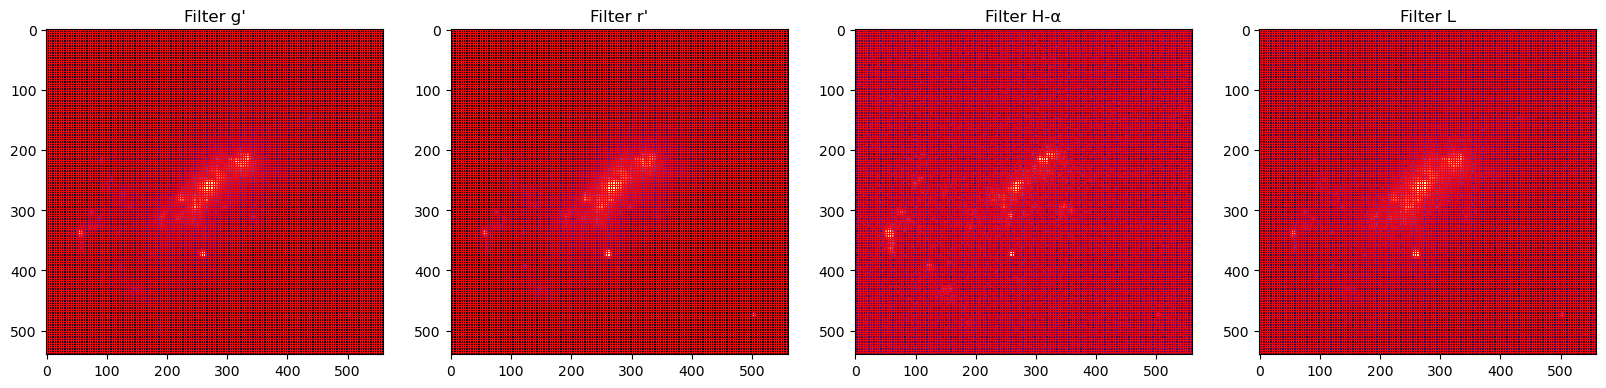

[[-2.84717767 -0.81995599 -1.85843865 ... -3.01546685 -0.45763604
  -1.58533685]
 [-1.77250115 -2.29920403 -0.25742547 ...  0.54448493 -2.66126458
  -2.90938775]
 [-0.62887017 -2.28406732 -3.08901421 ...  1.56421454 -0.73284356
  -3.9870855 ]
 ...
 [-1.69307916  1.09013923  0.72951301 ... -3.71822564 -1.80216424
  -0.83106439]
 [-2.72400872  0.3490351  -3.14814202 ... -2.60743157  0.16060431
   1.28430732]
 [-0.04102532 -0.98679559 -3.80509393 ... -3.31055657  1.1209925
  -0.2684118 ]]


In [44]:
# Visualize the images with sections
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
y_len, x_len = cropped_g.shape

# Function to plot image with sections
def plot_with_sections(ax, image, title):
    ax.imshow(image, cmap='magma', vmin=np.percentile(image, 0.1), vmax=np.percentile(image, 99.9))
    for i in range(0, y_len, region_size_define):
        ax.axhline(i, color='red', linewidth=0.7)
    for j in range(0, x_len, region_size_define):
        ax.axvline(j, color='red', linewidth=0.7)
    ax.set_title(title)

# Plot each image with sections
plot_with_sections(axs[0], clipped_g, "Filter g'")
plot_with_sections(axs[1], clipped_r, "Filter r'")
plot_with_sections(axs[2], clipped_ha, "Filter H-α")
plot_with_sections(axs[3], clipped_L, "Filter L")

plt.show()
print(clipped_g)



In [45]:
# Define colors for each spectral class
colors = {
    'BG': 'black',
    'O': 'blue',
    'B': 'cyan',
    'A': 'lavender',
    'F': 'green',
    'G': 'yellow',
    'K': 'orange',
    'M': 'red'
}

# Define B-V ranges for each spectral class
bv_ranges = {
    'BG': (-np.inf, -0.35),
    'O': (-0.35, -0.31),
    'B': (-0.35, 0),
    'A': (0, 0.27),
    'F': (0.27, 0.58),
    'G': (0.58, 0.89),
    'K': (0.89, 1.45),
    'M': (1.45, 1.63)
}


# Function to assign color based on B-V value
def bv_to_color(bv):
    for spectral_class, (low, high) in bv_ranges.items():
        if low <= bv < high:
            return colors[spectral_class]
    return 'black'  # Default color if no match

# Function to convert B-V array to color array
def convert_bv_to_color_array(bv_array):
    color_array = np.empty(bv_array.shape, dtype=object)
    for i in range(bv_array.shape[0]):
        for j in range(bv_array.shape[1]):
            color_array[i, j] = bv_to_color(bv_array[i, j])
    return color_array

Color_index_BV = (gr_to_BV(sectioned_color_index_g_min_r))
Spectral_colors = convert_bv_to_color_array(Color_index_BV)




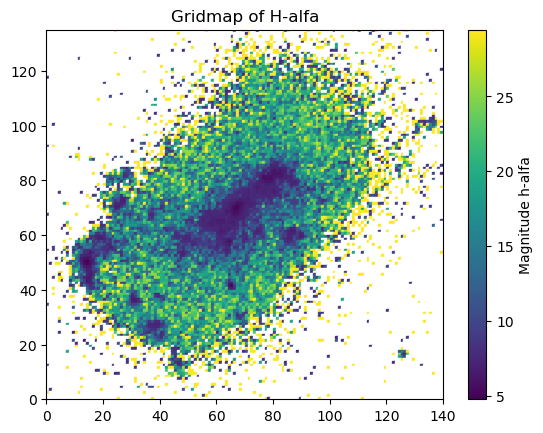

In [52]:
# Function to color cells based on average values
def plot_coloredmap_grid(cell_averages, num_rows, num_cols, lower_cutoff, upper_cutoff, title, fill_value=np.nan):
    fig, ax = plt.subplots()
    cell_averages = np.array(cell_averages)
    
    # Apply cutoff
    cell_averages = np.clip(cell_averages, lower_cutoff, upper_cutoff)
    
    # Handle fill_value
    cell_averages_masked = np.ma.masked_where(np.isnan(cell_averages), cell_averages)
    
    norm = mcolors.Normalize(vmin=np.min(cell_averages_masked), vmax=np.max(cell_averages_masked))
    cmap = plt.cm.viridis

    for i in range(num_rows):
        for j in range(num_cols):
            value = cell_averages[i, j]
            if np.isnan(value):
                color = 'white'  # or any other color to indicate masked areas
            else:
                color = cmap(norm(value))
            ax.add_patch(plt.Rectangle((j, num_rows - 1 - i), 1, 1, color=color))

    plt.title(title)
    ax.set_xlim(0, num_cols)
    ax.set_ylim(0, num_rows)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label("Magnitude h-alfa")
    plt.show()

def plot_colored_grid(cell_averages, num_rows, num_cols, lower_cutoff, upper_cutoff, title):
    fig, ax = plt.subplots()
    cell_averages = np.array(cell_averages)
    
    # Apply cutoff
    cell_averages = np.clip(cell_averages, lower_cutoff, upper_cutoff)

    # Convert B-V values to colors
    color_array = convert_bv_to_color_array(cell_averages)

    for i in range(num_rows):
        for j in range(num_cols):
            color = color_array[i, j]
            ax.add_patch(plt.Rectangle((j, num_rows - 1 - i), 1, 1, color=color))
            
    # Create custom legend
    legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=key)
                      for key, color in colors.items()]
    ax.legend(handles=legend_handles, title='Spectral Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(title)
    ax.set_xlim(0, num_cols)
    ax.set_ylim(0, num_rows)
    ax.set_aspect('equal')
    plt.show()
    
Color_index_BV = (gr_to_BV(sectioned_color_index_g_min_r))

# Match the two numbers with the shape of the file
#plot_colored_grid(Color_index_BV, 135, 140, -1, 2, "Gridmap of g' - r' converted to B - V")
plot_coloredmap_grid(sectioned_ha, 135, 140, np.min(sectioned_ha), np.max(sectioned_ha), "Gridmap of H-alfa")
#plot_coloredmap_grid(Color_index_BV, 135, 140, -1, 2, "Gridmap of g' - r' converted to B - V")

(135, 140)


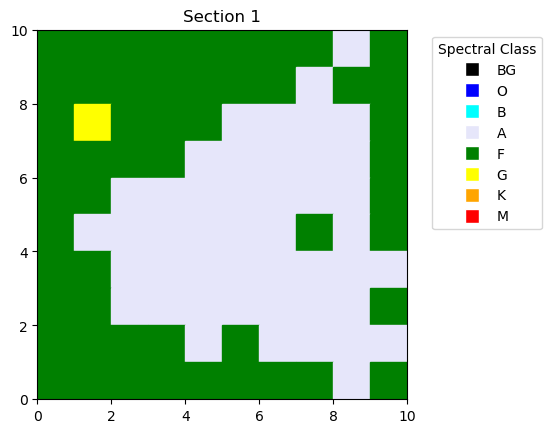

In [47]:
print(Color_index_BV.shape)

xmin, xmax, ymin, ymax = 77, 87, 50, 60

plot_colored_grid(Color_index_BV[ymin:ymax, xmin:xmax], ymax - ymin, xmax - xmin, -100000, 20000, "Section 1")

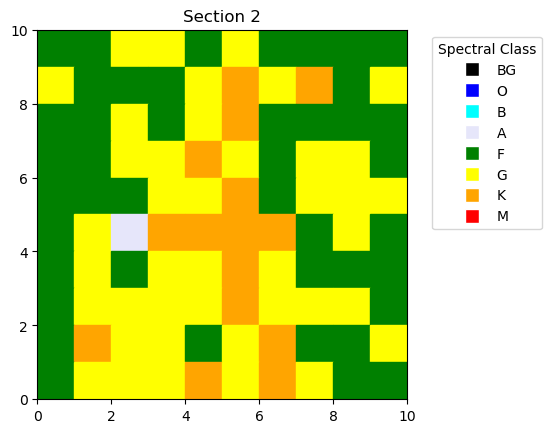

In [48]:
xmin, xmax, ymin, ymax = 70, 80, 77, 87


plot_colored_grid(Color_index_BV[ymin:ymax, xmin:xmax], ymax - ymin, xmax - xmin, -100000, 20000, "Section 2")


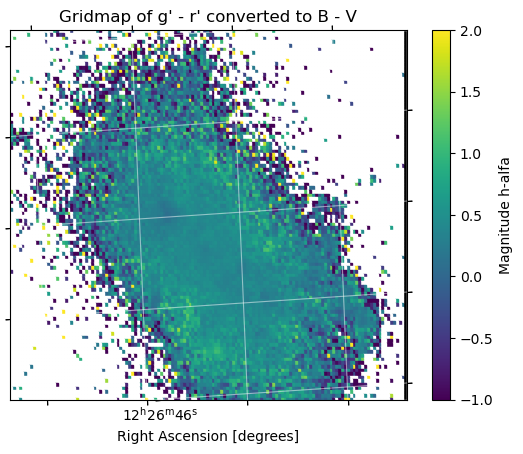

In [54]:
wcs = WCS(header_g)
z = ZScaleInterval()


#187.046325 deg 44.093558 deg

wx1, wy1 = wcs.wcs_world2pix(186.692,44.3029, 1) #lower limit
wx2, wy2 = wcs.wcs_world2pix(186.7077,44.32, 1) # upper limit




def plot_colored_grid_WCS(cell_averages, num_rows, num_cols, lower_cutoff, upper_cutoff, title):
    fig, ax = plt.subplots(figsize=(6, 4))
    cell_averages = np.array(cell_averages)
    ax = plt.subplot(111, projection=wcs)
    
    # Apply cutoff
    cell_averages = np.clip(cell_averages, lower_cutoff, upper_cutoff)

    # Convert B-V values to colors
    color_array = convert_bv_to_color_array(cell_averages)

    for i in range(num_rows):
        for j in range(num_cols):
            color = color_array[i, j]
            ax.add_patch(plt.Rectangle((j, num_rows - 1 - i), 1, 1, color=color))
            
    # Create custom legend
    legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=key)
                      for key, color in colors.items()]
    ax.legend(handles=legend_handles, title='Spectral Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("Right Ascension [degrees]")
    plt.ylabel("Declination [degrees]", labelpad=1)
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.set_autoscale_on(False)
    ax.set_xlim(wx1,wx2)
    ax.set_ylim(wy1,wy2)
    ax.set_facecolor('black')
    plt.show()

plot_colored_grid_WCS(Color_index_BV, 135, 140, -1, 2, "Gridmap of g' - r' converted to B - V")


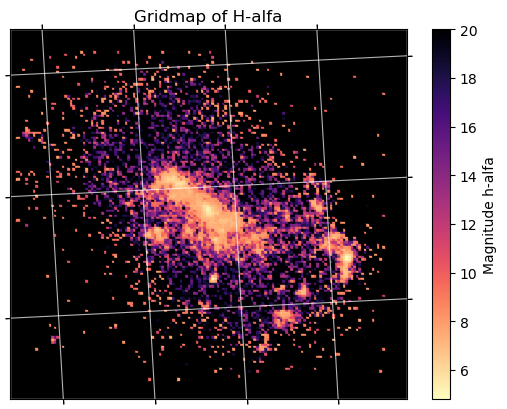

In [58]:
wcs = WCS(header_g)
z = ZScaleInterval()

#187.21159865  44.1709962489
#187.046325 deg 44.093558 deg


def plot_coloredmap_grid_wcs(cell_averages, num_rows, num_cols, lower_cutoff, upper_cutoff, title, fill_value=np.nan):
    ax = plt.subplot(111, projection=wcs)
    cell_averages = np.array(cell_averages)
    
    # Apply cutoff
    cell_averages = np.clip(cell_averages, lower_cutoff, upper_cutoff)
    
    # Handle fill_value
    cell_averages_masked = np.ma.masked_where(np.isnan(cell_averages), cell_averages)
    
    norm = mcolors.Normalize(vmin=np.min(cell_averages_masked), vmax=np.max(cell_averages_masked))
    cmap = plt.cm.magma.reversed()

    for i in range(num_rows):
        for j in range(num_cols):
            value = cell_averages[i, j]
            if np.isnan(value):
                color = 'black'  # or any other color to indicate masked areas
            else:
                color = cmap(norm(value))
            ax.add_patch(plt.Rectangle((j, num_rows - 1 - i), 1, 1, color=color))

    plt.xlabel("Right Ascension [degrees]")
    plt.ylabel("Declination [degrees]", labelpad=1)
    ax.coords.grid(color='white', alpha=0.7, linestyle='solid')
    ax.set_autoscale_on(False)
    ax.set_xlim(wx1, wx2)
    ax.set_ylim(wy1, wy2)
    
    plt.title(title)
    plt.gca().set_facecolor('black')
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label("Magnitude h-alfa")
    plt.show()
    
# 186.686 186.710 44.302 44.321
    
wx1, wy1 = wcs.wcs_world2pix(186.686,44.302, 1) #lower limit
wx2, wy2 = wcs.wcs_world2pix(186.710,44.321, 1) # upper limit
    
plot_coloredmap_grid_wcs(sectioned_ha, 135, 140, np.min(sectioned_ha), 20, "Gridmap of H-alfa")
    